In [1]:
import sys; sys.path.append('..'); from wwa import *

xn,xx,yn,yx = [120,140,10,20]
mapproj = cartopy.crs.PlateCarree()

In [2]:
def wrap_lon(ds):
    
    # method to wrap longitude from (0,360) to (-180,180)
    
    if "longitude" in ds.coords:
        lon = "longitude"
        lat = "latitude"
    elif "lon" in ds.coords:
        lon = "lon"
        lat = "lat"
    else: 
        # can only wrap longitude
        return ds
    
    if ds[lon].max() > 180:
        ds[lon] = (ds[lon].dims, (((ds[lon].values + 180) % 360) - 180), ds[lon].attrs)
        
    if lon in ds.dims:
        ds = ds.reindex({ lon : np.sort(ds[lon]) })
        ds = ds.reindex({ lat : np.sort(ds[lat]) })
    return ds

# Gridded data

In [3]:
# load PI and associated variables
ds = wrap_lon(xr.merge([xr.open_dataset("pi_era5_daily.nc").vmax, xr.open_dataset("pi-vars_era5_daily.nc")]))
ds = ds.transpose("lat", "lon", "p", "time")

In [4]:
ts = ds.sel(lon = slice(xn,xx), lat = slice(yn,yx)).mean(["lat", "lon"])

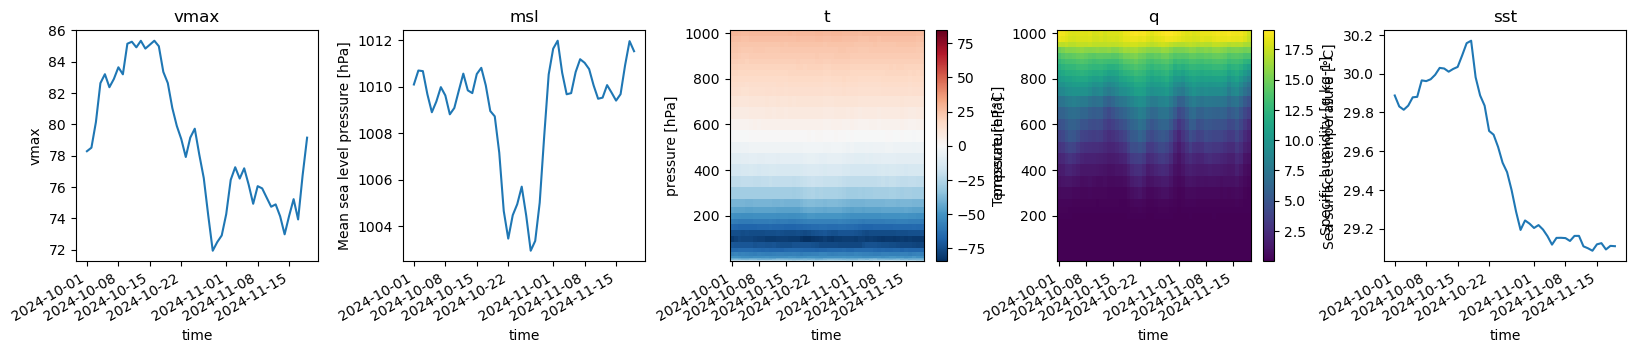

In [5]:
fig,axs = plt.subplots(ncols = 5, figsize = (20,3), dpi = 100)
plt.subplots_adjust(wspace = 0.35)

for i in range(5):
    ax = axs[i]
    vnm = list(ts.data_vars)[i]
    ts[vnm].plot(ax = ax)
    ax.set_title(vnm)

# IBtracs

Trami/Kristine (19-29 Oct)  
Kong-Rey/Leon (24 Oct-1 Nov)  
Yinxing/Marce (3-13 Nov)  
Toraji/Nika (8-15 Nov)  
Man-Yi/Pepito (9-20 Nov)  
Usagi/Ofel (9-16 Nov)  

In [6]:
df = pd.read_csv("ibtracs.last3years.list.v04r01.csv", parse_dates = ["ISO_TIME"], index_col = "ISO_TIME")
df = df.loc[df.NAME.isin(["TRAMI", "KONG-REY", "YINXING", "TORAJI", "MAN-YI", "USAGI"]),
            ["NAME", "LAT", "LON", "LANDFALL", "USA_WIND", "USA_PRES", "STORM_SPEED", "STORM_DIR"]]

# add values along storm track
df["PI"] = [ds.vmax.sel(time = datetime(int(k[:4]), int(k[5:7]), int(k[8:10]))).sel(lon = r.LON, lat = r.LAT, method = "nearest").values for k, r in df.iterrows()]
df["sst"] = [ds.sst.sel(time = datetime(int(k[:4]), int(k[5:7]), int(k[8:10]))).sel(lon = r.LON, lat = r.LAT, method = "nearest").values for k, r in df.iterrows()]
df["psl"] = [ds.msl.sel(time = datetime(int(k[:4]), int(k[5:7]), int(k[8:10]))).sel(lon = r.LON, lat = r.LAT, method = "nearest").values for k, r in df.iterrows()]

# fix dates
df.index = [datetime(int(d[:4]), int(d[5:7]), int(d[8:10]), int(d[11:13])) for d in df.index]

df.to_csv("tc-tracks.csv")

/var/tmp/pbs.387217.pbs/ipykernel_880669/911301395.py:1: DtypeWarning: Columns (1,2,8,9,14,19,20,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ibtracs.last3years.list.v04r01.csv", parse_dates = ["ISO_TIME"], index_col = "ISO_TIME")


In [7]:
# remove tracks after landfall
df = df.loc[~((df.NAME == "KONG-REY") & (df.index > "2024-10-31 09:00:00"))]
df = df.loc[~((df.NAME == "TORAJI") & (df.index > "2024-11-11 09:00:00"))]

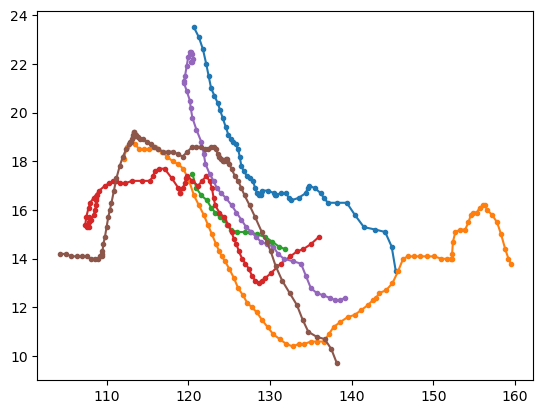

In [8]:
for nm in np.unique(df.NAME):
    plt.plot(df.loc[df.NAME == nm].LON, df.loc[df.NAME == nm].LAT, marker = ".")

In [219]:
# load PI and associated variables
ds = wrap_lon(xr.merge([xr.open_dataset("pi_era5_daily.nc").vmax, xr.open_dataset("pi-vars_era5_daily.nc")]))
ds = ds.transpose("lat", "lon", "p", "time")
ts_g = ds.sel(lon = slice(xn,xx), lat = slice(yn,yx), time = slice("2024-10-15", None)).mean(["lat", "lon"]).rename(vmax = "PI", msl = "psl")

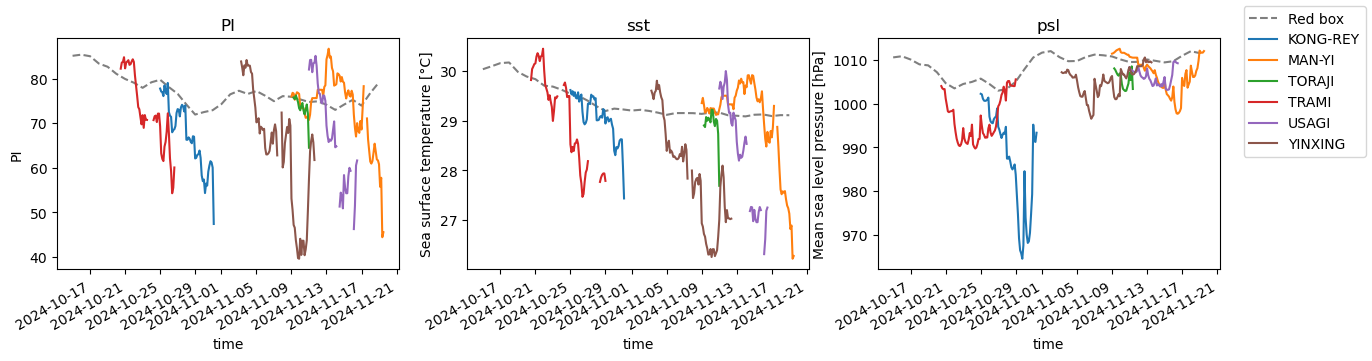

In [230]:
fig, axs = plt.subplots(ncols = 3, figsize = (15,3), dpi = 100)

for i in range(3):
    ax = axs[i]
    vnm = ["PI", "sst", "psl"][i]
    
    ts_g[vnm].plot(ax = ax, color = "k", alpha = 0.5, ls = "--")
    
    for nm in np.unique(df.NAME):
        ts = df.loc[df.NAME == nm]
        ax.plot(ts.index, ts[vnm], label = nm)
        
    ax.set_title(vnm)
fig.legend(["Red box"] + list(np.unique(df.NAME)))

## Visualise SST change along track
Is there a drop in SSTs as the TC passes through?

In [82]:
# load SSTs, thin to every three hours
da = convert_units_to(wrap_lon(xr.open_mfdataset("data/era5_pi-sfc_2024-*_hourly.nc").sst).load().reset_coords(drop = True), "degC")
da = da.sel(valid_time = da.valid_time.dt.hour.isin([0,3,6,9,12,15,18,21,24]))

In [112]:
# load tracks
df = pd.read_csv("ibtracs.last3years.list.v04r01.csv", parse_dates = ["ISO_TIME"], index_col = "ISO_TIME")
df = df.loc[df.NAME.isin(["TRAMI", "KONG-REY", "YINXING", "TORAJI", "MAN-YI", "USAGI"]),
            ["NAME", "LAT", "LON", "LANDFALL", "USA_WIND", "USA_PRES", "STORM_SPEED", "STORM_DIR"]]
df.index = [datetime(int(d[:4]), int(d[5:7]), int(d[8:10]), int(d[11:13])) for d in df.index]

# select one track of interest
df = df.loc[df.NAME == "USAGI"]

/var/tmp/pbs.387217.pbs/ipykernel_880669/1765821423.py:2: DtypeWarning: Columns (1,2,8,9,14,19,20,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ibtracs.last3years.list.v04r01.csv", parse_dates = ["ISO_TIME"], index_col = "ISO_TIME")


In [113]:
track = xr.concat([da.sel(longitude = r.LON, latitude = r.LAT, method = "nearest").expand_dims(track_time = [k]) for k, r in df.iterrows()], "track_time")

In [114]:
track = track.sel(valid_time = slice(track.track_time.min(), track.track_time.max())).transpose()

Text(0, 0.5, 'Time of SST reanalysis')

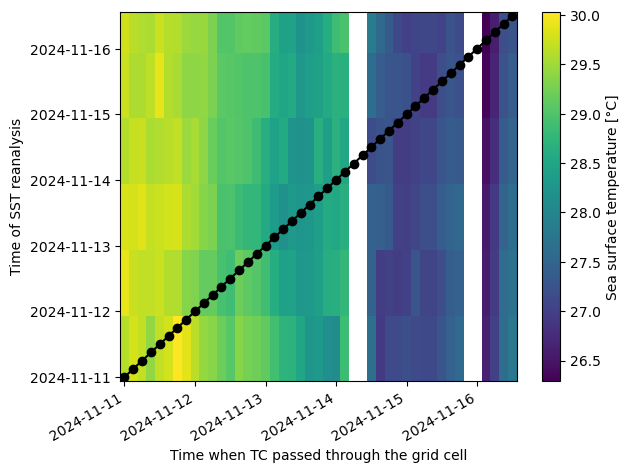

In [117]:
# Compare SST estimates along the storm track at different times
track.plot()
ax = plt.gca()

plt.plot(track.valid_time, track.track_time, color = "k", marker = "o")
ax.set_xlabel("Time when TC passed through the grid cell")
ax.set_ylabel("Time of SST reanalysis")

## What about PI?

In [121]:
# load SSTs, thin to every three hours
da = wrap_lon(xr.open_mfdataset("data/pi_era5_daily.nc").vmax).load()

In [123]:
# load tracks
df = pd.read_csv("ibtracs.last3years.list.v04r01.csv", parse_dates = ["ISO_TIME"], index_col = "ISO_TIME")
df = df.loc[df.NAME.isin(["TRAMI", "KONG-REY", "YINXING", "TORAJI", "MAN-YI", "USAGI"]),
            ["NAME", "LAT", "LON", "LANDFALL", "USA_WIND", "USA_PRES", "STORM_SPEED", "STORM_DIR"]]
df.index = [datetime(int(d[:4]), int(d[5:7]), int(d[8:10]), int(d[11:13])) for d in df.index]

# select one track of interest
df = df.loc[df.NAME == "USAGI"]

/var/tmp/pbs.387217.pbs/ipykernel_880669/1765821423.py:2: DtypeWarning: Columns (1,2,8,9,14,19,20,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ibtracs.last3years.list.v04r01.csv", parse_dates = ["ISO_TIME"], index_col = "ISO_TIME")


In [125]:
track = xr.concat([da.sel(lon = r.LON, lat = r.LAT, method = "nearest").expand_dims(track_time = [k]) for k, r in df.iterrows()], "track_time")

In [127]:
track = track.sel(time = slice(track.track_time.min(), track.track_time.max())).transpose()

Text(0, 0.5, 'Time of SST reanalysis')

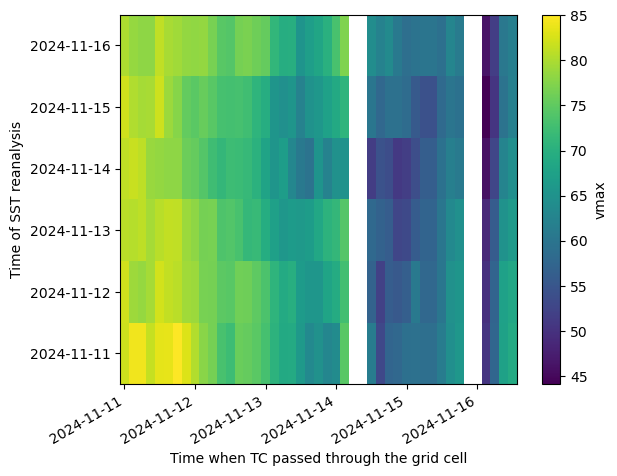

In [129]:
# Compare SST estimates along the storm track at different times
track.plot()
ax = plt.gca()

# plt.plot(track.time, track.track_time, color = "k", marker = "o")
ax.set_xlabel("Time when TC passed through the grid cell")
ax.set_ylabel("Time of SST reanalysis")

# WNP subtropical high

In [137]:
z500 = xr.open_dataset("era5_z500_daily_110-150E_15-30N_-999-lastyear.nc").z500 - xr.open_dataset("iera5_z500_daily_0-360E_0-40N_-999-lastyear_0-360E_0-40N_-999-lastyear_n.nc").z500

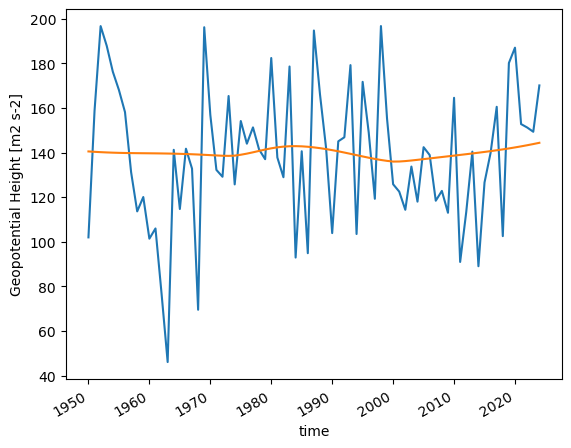

In [155]:
ts = z500.mean(["lat", "lon"]).resample(time = "YS").mean()
ts.plot()
plt.plot(ts.time, lowess(ts, ts.time)[:,1])

# Accumulated cyclone energy

In [6]:
df = pd.read_csv("ibtracs.WP.list.v04r01.csv", parse_dates = ["ISO_TIME"])
# df = pd.read_csv("ibtracs.last3years.list.v04r01.csv", parse_dates = ["ISO_TIME"], index_col = "ISO_TIME")
df = df.loc[df.BASIN == "WP",  ["NAME", "SID", "ISO_TIME", "LAT", "LON", "LANDFALL", "USA_WIND", "USA_PRES", "STORM_SPEED", "STORM_DIR"]]
df["SON"] = [int(d[5:7]) in [9,10,11] for d in df.ISO_TIME]
df["YEAR"] = [int(d[:4]) for d in df.ISO_TIME]

df["LAT"] = [float(l) for l in df.LAT]
df["LON"] = [float(l) for l in df.LON]

df["CE_WIND"] = [np.nan if w == " " else int(w) for w in df.USA_WIND]
df["CE"] = [w**2 / 10**4 if w >= 34 else np.nan for w in df.CE_WIND]

/var/tmp/pbs.346522.pbs/ipykernel_1663764/3186522381.py:1: DtypeWarning: Columns (1,2,8,9,14,142,143,144,172,173) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ibtracs.WP.list.v04r01.csv", parse_dates = ["ISO_TIME"])


In [7]:
# criteria for inclusion
df["IN_BOX"] = (df.LON <= 120) & (df.LON <= 125) & (df.LAT >= 15) & (df.LAT <= 20)

In [8]:
# thin the dataframe
df_6h = df.loc[[int(d[11:13]) in [6,12,18,24] for d in df.ISO_TIME]]

In [15]:
ace = merge_byindex([df_6h[["SID", "YEAR"]].groupby("SID").max(), df_6h[["SID", "SON"]].groupby("SID").max(), df_6h[["SID", "IN_BOX"]].groupby("SID").max(), df_6h[["SID", "CE"]].groupby("SID").sum()])

ace = ace.loc[ace.IN_BOX]
ace = ace.loc[ace.YEAR >= 1980]

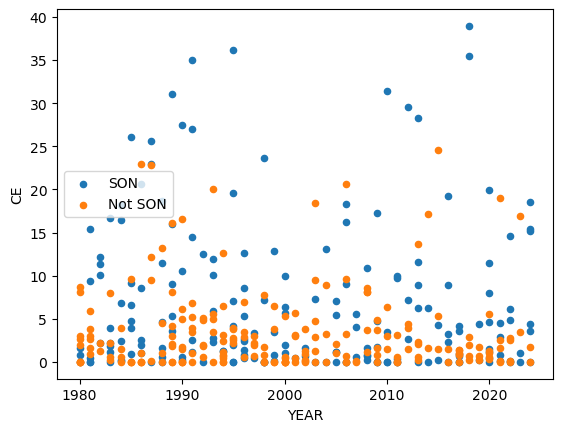

In [16]:
ace.loc[ace.SON].plot(kind = "scatter", x = "YEAR", y = "CE", label = "SON")
ace.loc[~ace.SON].plot(kind = "scatter", x = "YEAR", y = "CE", ax = plt.gca(), color = "tab:orange", label = "Not SON")
plt.legend(loc = "center left")

<AxesSubplot: xlabel='YEAR', ylabel='CE'>

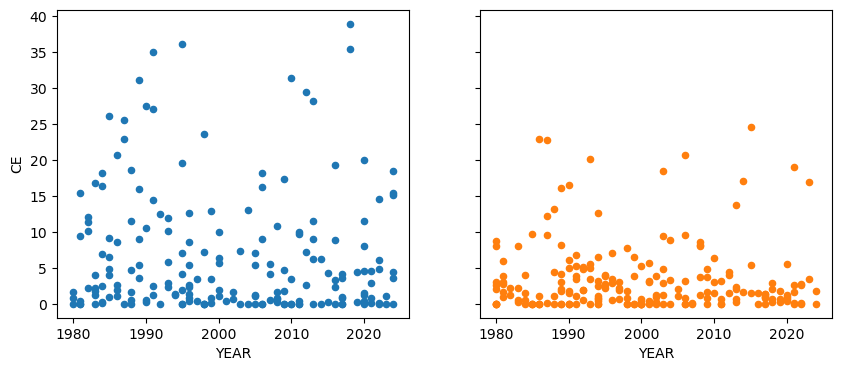

In [378]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100, sharex = True, sharey = True)

ace.loc[ace.SON].plot(kind = "scatter", x = "YEAR", y = "CE", ax = axs[0])
ace.loc[~ace.SON].plot(kind = "scatter", x = "YEAR", y = "CE", ax = axs[1], color = "tab:orange")

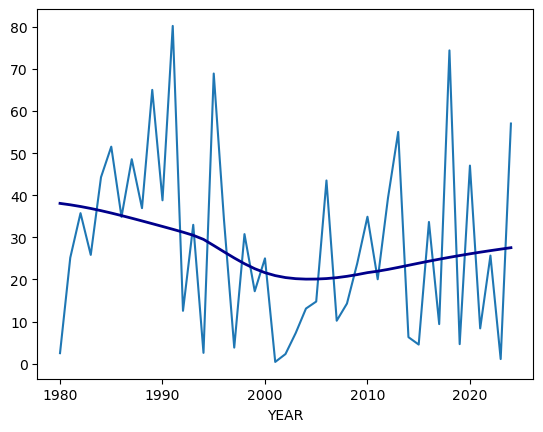

In [384]:
ts = ace.loc[ace.SON].groupby("YEAR").sum()
ts.CE.plot()
# ace.loc[~ace.SON].groupby("YEAR").sum().CE.plot()
plt.plot(ts.index, lowess(ts.CE, ts.index)[:,1], color = "darkblue", lw = 2)

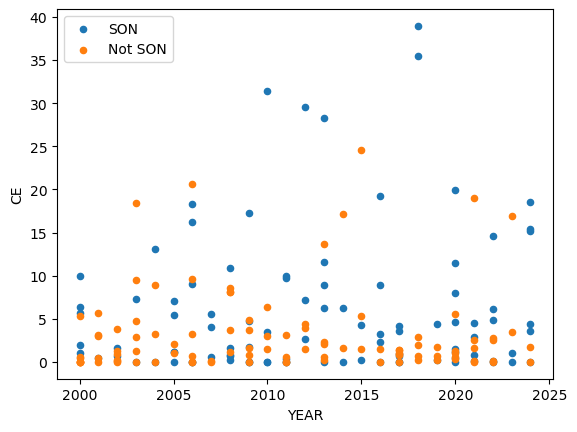

In [339]:
ace.loc[(ace.YEAR >= 2000) & (ace.SON)].plot(kind = "scatter", x = "YEAR", y = "CE", label = "SON")
ace.loc[(ace.YEAR >= 2000) & (~ace.SON)].plot(kind = "scatter", x = "YEAR", y = "CE", ax = plt.gca(), color = "tab:orange", label = "Not SON")
plt.legend(loc = "upper left")

In [30]:
# find historic examples for comparison
df.loc[df.SID == ace.loc[(ace.YEAR == 2010) & (ace.CE > 30)].index[0]]     # October 11-24 2010
df.loc[df.SID == ace.loc[(ace.YEAR == 2016) & (ace.CE > 18)].index[0]]     # October 14-26 2016
df.loc[df.SID == ace.loc[(ace.YEAR == 2020) & (ace.CE > 18)].index[0]]     # October 25 - November 6th 2020

,NAME,SID,ISO_TIME,LAT,LON,LANDFALL,USA_WIND,USA_PRES,STORM_SPEED,STORM_DIR,SON,YEAR,CE_WIND,CE,IN_BOX
237589,GONI,2020299N11144,2020-10-25 06:00:00,10.6,143.9,1454,15,1009,9,345,True,2020,15.0,NaN,False
237590,GONI,2020299N11144,2020-10-25 09:00:00,11.0,143.8,1500,15,1009,9,340,True,2020,15.0,NaN,False
237591,GONI,2020299N11144,2020-10-25 12:00:00,11.4,143.6,1548,15,1008,8,320,True,2020,15.0,NaN,False
237592,GONI,2020299N11144,2020-10-25 15:00:00,11.6,143.3,1577,15,1008,9,305,True,2020,15.0,NaN,False
237593,GONI,2020299N11144,2020-10-25 18:00:00,11.9,142.9,1599,15,1007,10,315,True,2020,15.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237681,GONI,2020299N11144,2020-11-05 18:00:00,13.9,110.2,65,25,1007,8,280,True,2020,25.0,NaN,False
237682,GONI,2020299N11144,2020-11-05 21:00:00,14.0,109.8,21,25,1008,9,280,True,2020,25.0,NaN,False
237683,GONI,2020299N11144,2020-11-06 00:00:00,14.1,109.3,0,25,1009,12,285,True,2020,25.0,NaN,False
237684,GONI,2020299N11144,2020-11-06 03:00:00,14.3,108.7,0,23,1010,14,285,True,2020,23.0,NaN,False


In [32]:
ids = [ace.loc[(ace.YEAR == 2010) & (ace.CE > 30)].index[0],
       ace.loc[(ace.YEAR == 2016) & (ace.CE > 18)].index[0],
       ace.loc[(ace.YEAR == 2020) & (ace.CE > 18)].index[0]]

In [38]:
df.loc[df.SID.isin(ids)].LON.max()

147.1

# Cooling after TC passage

In [3]:
sst = xr.open_dataset("era5_sst_previous-tc-tracks.nc").sst

df1 = df.loc[df.SID == ace.loc[(ace.YEAR == 2010) & (ace.CE > 30)].index[0]] 
df1["DATE"] = [t[:10] for t in df1.ISO_TIME]

dates = sorted(list(set(df1.DATE)))

sst_diff = sst.diff("time", label = "lower")

NameError: name 'df' is not defined

In [ ]:
nc = 7; nr = 2
plot_kwargs = {"cmap" : "RdBu_r", "norm" : MidpointNormalize(vmin = -5, vmax = 5)}

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4, nr*4), subplot_kw = {"projection" : mapproj, "extent" : (120,140,5,25)}, dpi = 100, sharex = True, sharey = True)

for i in range(len(dates)):
    ax = axs.flatten()[i]
    d = dates[i]
    
    dfd = df1.loc[df1.DATE == d]
    
    sst_diff.sel(time = d).plot(ax = ax, add_colorbar = False)
    ax.scatter(dfd.LON, dfd.LAT, marker = "x", color = "k")
    
    ax.coastlines()
    ax.gridlines (color = "k", alpha = 0.2)
    
for i in range(len(dates), nr*nc): axs.flatten()[i].set_axis_off()

In [12]:
ds = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/pi_philippines/merra2_2024/MERRA2_400.instM_3d_asm_Np.202403.nc4.nc4")